In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
def sort_files(fname):
    fname = fname.replace('.tif', '')
    fname = fname.replace('_mask', '')
    parts = fname.split('_')
    return int(parts[0]) * 1000 + int(parts[1])

In [3]:
data_path = 'raw'
train_data_path = os.path.join(data_path, 'train')
images = os.listdir(train_data_path)
images = sorted(images, key=sort_files)

In [4]:
image_data = []

for image_name in images:
    if 'mask' in image_name:
        continue
        
    name = image_name.split('.')[0]
    image_mask_name = name + '_mask.tif'
    img_mask = cv2.imread(os.path.join(train_data_path, image_mask_name), cv2.IMREAD_GRAYSCALE)
    
    data = {
        'image_name': image_name,
        'mask_image_name': image_mask_name,
        'is_found': img_mask.max() > 0,
        'name': name
    }
    image_data.append(data)
    
data = pd.DataFrame(image_data)
data.set_index('name', inplace=True)
data.head()

,image_name,is_found,mask_image_name
name,,,
1_1,1_1.tif,True,1_1_mask.tif
1_2,1_2.tif,True,1_2_mask.tif
1_3,1_3.tif,True,1_3_mask.tif
1_4,1_4.tif,True,1_4_mask.tif
1_5,1_5.tif,False,1_5_mask.tif


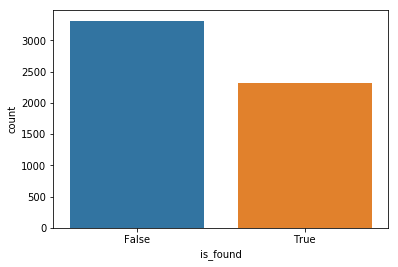

In [5]:
sns.countplot(x="is_found", data=data)
plt.show()

,image_name,is_found,mask_image_name,type
name,,,,
1_85,1_85.tif,True,1_85_mask.tif,train
38_112,38_112.tif,False,38_112_mask.tif,train
32_101,32_101.tif,False,32_101_mask.tif,test
19_14,19_14.tif,True,19_14_mask.tif,test
2_39,2_39.tif,False,2_39_mask.tif,validation
42_53,42_53.tif,False,42_53_mask.tif,validation


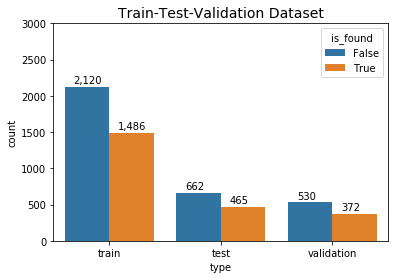

In [6]:
split_ratio = 0.2
X = data
y = data['is_found']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=split_ratio, 
                                                    stratify=X['is_found'], 
                                                    random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                                test_size=split_ratio, 
                                                                stratify=X_train['is_found'], 
                                                                random_state=42)
X_train_new = X_train.copy()
X_train_new['type']='train'
X_train = X_train_new

X_test_new = X_test.copy()
X_test_new['type']='test'
X_test = X_test_new

X_validation_new = X_validation.copy()
X_validation_new['type']='validation'
X_validation = X_validation_new

data = pd.concat([X_train, X_test, X_validation], axis='index')
display(data.groupby('type').head(2))

ax = sns.countplot(x="type", hue="is_found", data=data)
ax.set_title('Train-Test-Validation Dataset', fontsize=14)
ax.set_ylim((0, 3000))
for rect in ax.patches:
    x = rect.get_x() + 0.08
    y = rect.get_y() + rect.get_height() + 50
    ax.text(x, y, "{:,}".format(rect.get_height()), color='black')
plt.show()

In [7]:
def img_to_narray(image_name):
    img = cv2.imread(os.path.join(train_data_path, image_name), cv2.IMREAD_GRAYSCALE)
    return np.array([img])

def create_image_arrays(data_type, learn_type):
    image_rows = 420
    image_cols = 580
    filenames = data.query('type=="{}"'.format(learn_type))[data_type].tolist()
    result = np.ndarray((len(filenames), 1, 420, 580), dtype=np.uint8)
    for index, filename in enumerate(filenames):
        result[index] =  img_to_narray(filename)
    return result

In [8]:
X_train = create_image_arrays('image_name', 'train')
y_train = create_image_arrays('mask_image_name', 'train')
X_test = create_image_arrays('image_name', 'test')
y_test = create_image_arrays('mask_image_name', 'test')
X_validation = create_image_arrays('image_name', 'validation')
y_validation = create_image_arrays('mask_image_name', 'validation')

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)
print('Shape of X_validation:', X_validation.shape)
print('Shape of y_validation:', y_validation.shape)

Shape of X_train: (3606, 1, 420, 580)
Shape of y_train: (3606, 1, 420, 580)
Shape of X_test: (1127, 1, 420, 580)
Shape of y_test: (1127, 1, 420, 580)
Shape of X_validation: (902, 1, 420, 580)
Shape of y_validation: (902, 1, 420, 580)


In [9]:
def display_train_image(index):
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)
    ax1.imshow(X_train[index, 0], cmap='gray')
    ax1.set_title('X_train[{}]'.format(index))
    ax2.imshow(y_train[index, 0], cmap='gray')
    ax2.set_title('y_train[{}]'.format(index))
    plt.show()
    
def display_test_image(index):
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)
    ax1.imshow(X_test[index, 0], cmap='gray')
    ax1.set_title('X_test[{}]'.format(index))
    ax2.imshow(y_test[index, 0], cmap='gray')
    ax2.set_title('y_test[{}]'.format(index))
    plt.show()
    
def display_validation_image(index):
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)
    ax1.imshow(X_validation[index, 0], cmap='gray')
    ax1.set_title('X_test[{}]'.format(index))
    ax2.imshow(y_validation[index, 0], cmap='gray')
    ax2.set_title('y_validation[{}]'.format(index))
    plt.show()

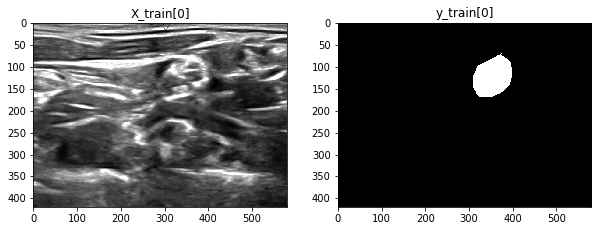

In [10]:
display_train_image(0)

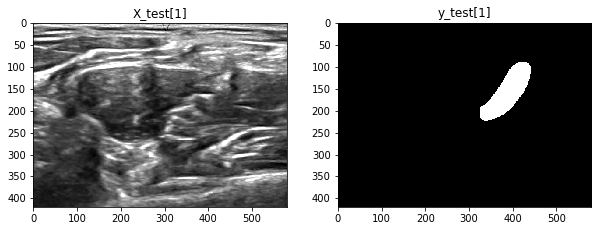

In [11]:
display_test_image(1)

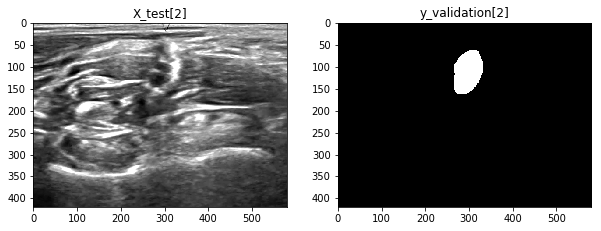

In [12]:
display_validation_image(2)

In [13]:
data.to_csv('train-test-dataset.csv', index=False)

In [14]:
np.save('imgs_train.npy', X_train)
np.save('imgs_mask_train.npy', y_train)
np.save('imgs_test.npy', X_test)
np.save('imgs_mask_test.npy', y_test)
np.save('imgs_validation.npy', X_validation)
np.save('imgs_mask_validation.npy', y_validation)